# BE Hawkes

## Importation des librairies

In [29]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()

from ipywidgets import interact
import ipywidgets as widgets

from numba import njit, prange
import time

## Algorithmes de simulation

In [2]:
def Simulate_HPP(lamb, T):
    n = 0
    t = [- np.log(npr.random()) / lamb]
    while t[-1] <= T:
        u = npr.random()
        w = - np.log(u) / lamb
        t.append(t[-1] + w)
    return t

In [3]:
def Simulate_IPP(lamb, T, lamb_bar):
    n = 0
    m = 0
    t = []
    s = 0
    
    while s < T:
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        if D < lamb(s)/lamb_bar:
            t.append(s)
    if t[-1] < T:
        return t
    else:
        return t[:-1]

In [30]:
@njit
def lambda_bar(mu, alpha, beta, s, tau):
    S = mu
    for t in tau:
        S += alpha * np.exp(- beta * (s - t))
    return S

@njit
def Simulate_Hawkes(mu, alpha, beta, T):    
    tau = [0.0]  # Pour pas faire râler Numba
    s = 0
    while s < T:
        u = npr.random()
        lamb_bar = lambda_bar(mu, alpha, beta, s, tau)
        w = -np.log(u) / lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar(mu, alpha, beta, s, tau):
            tau.append(s)
        
    # On enlève le premier 0 dans les deux cas
    if tau[-1] < T:
        return tau[1:]
    else:
        return tau[1:-1]
    
def lamb_Hawkes(t, tau, mu, alpha, beta):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) for Tau in tau_inf])

## Fonctions d'affichage

In [5]:
def plot_PP(t):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.step([0] + t, [0] + list(range(len(t))))
    plt.scatter(t,[0] * len(t), color='r')
    for h, T in enumerate(t):
        plt.plot([T, T], [0, h], '--', color="darkred")
    ax.set_xlabel("t", fontsize=20)
    ax.set_ylabel("N(t)", fontsize=20)
    plt.show()

In [6]:
def plot_Hawkes(mu, alpha, beta, T):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau = Simulate_Hawkes(mu, alpha, beta, T)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes(t, tau, mu, alpha, beta) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes(Tau, tau, mu, alpha, beta)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t",fontsize=20)
    ax[0].set_ylabel("N(t)",fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)",fontsize=20)
    
    ax[0].set_title("Processus de Hawkes, " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

## Visualisation

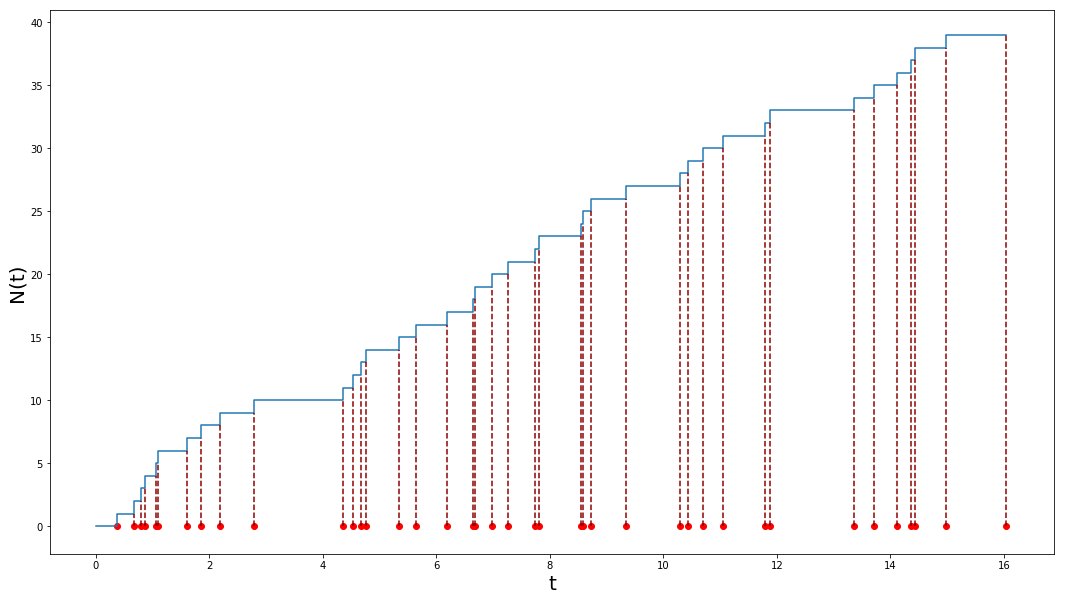

In [7]:
#HPP
plot_PP(Simulate_HPP(3, 15))

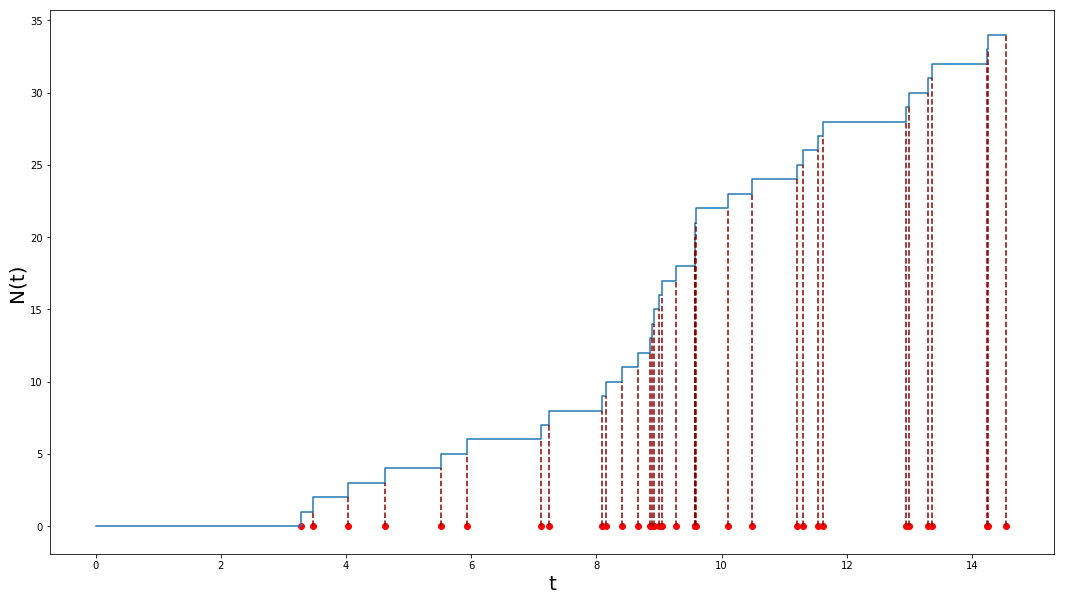

In [8]:
#IPP
def lamb0(t):
    return t/4
plot_PP(Simulate_IPP(lamb0,15,5))

In [9]:
mu = 1.2
alpha = 0.6
beta = 0.8
T = 15

@interact(alpha=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.6, continuous_update=False),
          beta=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.8, continuous_update=False))
def test_param(alpha, beta):
    if alpha < beta:
        plot_Hawkes(mu, alpha, beta, T)
    else:
        print("Alpha doit être inférieur à beta !")

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='alpha', max=3.0), FloatSlid…

Avec $\alpha = 0$, on retrouve un PP homogène.

Plus $\alpha$ est grand, plus le processus saute souvent et plus il s'auto-excite.

Plus $\beta$ est grand, plus la décroissance de $\lambda$ est rapide

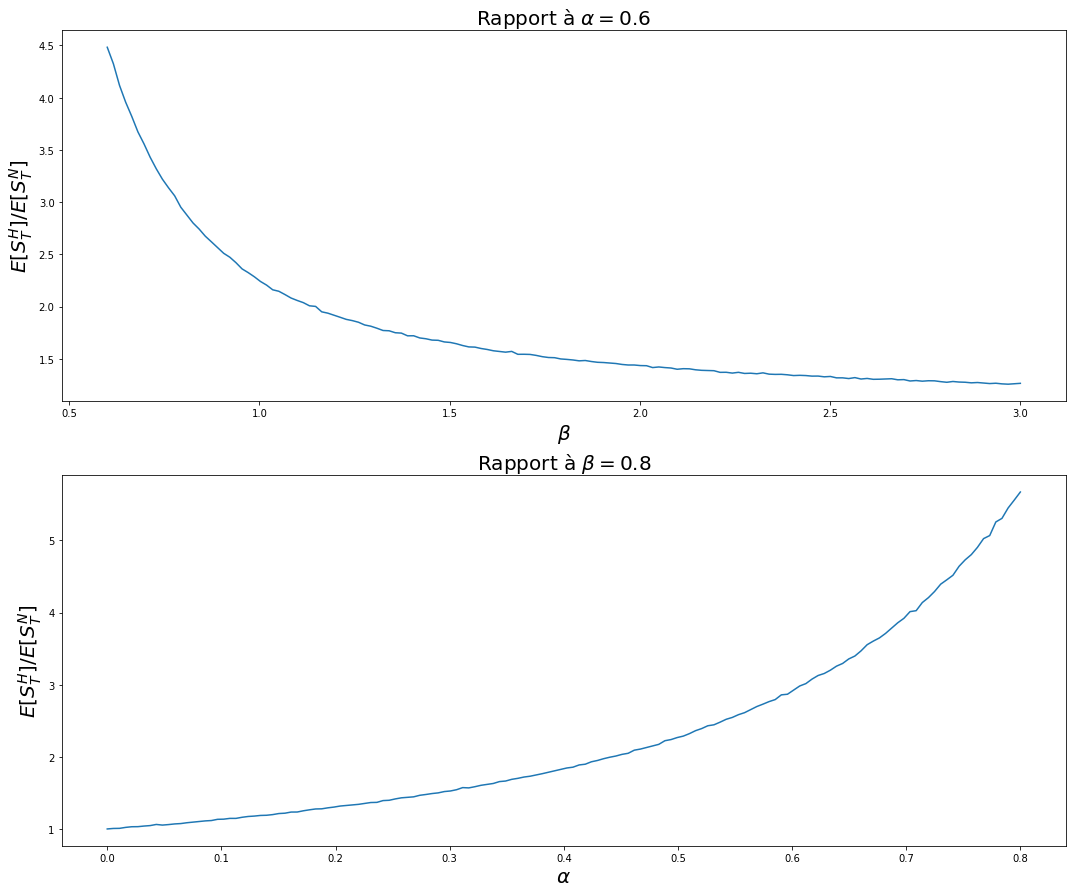

In [39]:
mu = 1.2
sigma = 1
T = 10
alpha = 0.6
beta = 0.8
N = 20000

@njit
def X_Hawkes(mu, sigma, alpha, beta, T):
    '''Calcul des claims jusqu'au temps T '''
    N = len(Simulate_Hawkes(mu, alpha, beta, T))
    X = np.exp(npr.normal(mu, sigma, N)) #Loi logNormale
    return X

@njit(parallel=True)
def Rapport_ST(mu, sigma, alpha, beta, T, N):
    """Calcul du rapport entre l'espérance de S_T avec le processus de Hawkes estimée par Monte-Carlo 
    et l'espérance de S_T du processus de Poisson homogène de paramètre mu"""
    nb_beta = 150
    nb_alpha = 150
    range_beta = np.linspace(alpha, 3, nb_beta)
    range_alpha = np.linspace(0, beta, nb_alpha)
    S_beta = np.zeros(nb_beta)
    S_alpha = np.zeros(nb_alpha)
    for i in prange(N): 
        S_beta += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for beta in range_beta])
        S_alpha += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha])
    S_beta = S_beta / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    S_alpha = S_alpha / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    
    return range_alpha, S_alpha, range_beta, S_beta
    
def plot_rapports(range_alpha, S_alpha, range_beta, S_beta):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 15))
    
    ax[0].plot(range_beta, S_beta)
    ax[0].set_title("Rapport à " + r"$\alpha = $" + str(alpha), fontsize=20)
    ax[0].set_xlabel(r"$\beta$", fontsize=20)
    ax[0].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)

    ax[1].plot(range_alpha, S_alpha)
    ax[1].set_title("Rapport à " + r"$\beta = $" + str(beta), fontsize=20)
    ax[1].set_xlabel(r"$\alpha$", fontsize=20)
    ax[1].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)
    
    plt.show()
    
plot_rapports(*Rapport_ST(mu, sigma, alpha, beta, T, N))

On souhaite maintenant prendre en compte l'importance du sinistre. Au delà d'un certain seuil on considérera que les répercutions du sinistre sont plus importantes. Par exemple, plus un accident est important, plus le nombre de soins médicaux qu'il engendre le seront également. 

Nous allons donc modéliser  $\lambda$ par $\mu + \sum_{{k :t_k < t}}\alpha \exp({-\beta (t-t_k)}) \mathbb{1}_{X_k > S} $
avec $X_k$ la valeur du sinistre et $S$ le seuil. 

In [46]:
def Simulate_Hawkes_Seuil(mu, alpha, beta, T, S):
    tau = []
    s = 0
    X = []
    while s < T:
        X += list(np.exp(npr.normal(mu, sigma, 1))) #Loi logNormale
        lamb_bar = mu + np.sum([alpha * np.exp(- beta * (s - t)) * (X[ind] > S) for ind, t in enumerate(tau)])
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < mu + np.sum([alpha * np.exp(- beta * (s - t)) * (X[ind] > S) for ind, t in enumerate(tau)]):
            tau += [s]
        else:
            del X[-1]
        
        
    if tau[-1] < T:
        return tau, X
    else:
        return tau[:-1], X[:-1]

def lamb_Hawkes_Seuil(t, tau, mu, alpha, beta, X, S):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) * (X[ind] > S) for ind, Tau in enumerate(tau_inf)])

Evaluation du seuil : 

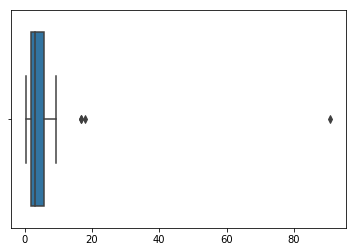

In [47]:
T=15
X = X_Hawkes(mu, sigma, alpha, beta, T)
sns.boxplot(X)
plt.show()

In [48]:
S = np.quantile(X,0.75)
S

5.768311156182158

In [49]:
def plot_Hawkes_Seuil(mu, alpha, beta, T, S):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau, X = Simulate_Hawkes_Seuil(mu, alpha, beta, T, S)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes_Seuil(t, tau, mu, alpha, beta, X, S) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes_Seuil(Tau, tau, mu, alpha, beta, X, S)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t",fontsize=20)
    ax[0].set_ylabel("N(t)",fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)",fontsize=20)
    
    ax[0].set_title("Processus de Hawkes, " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

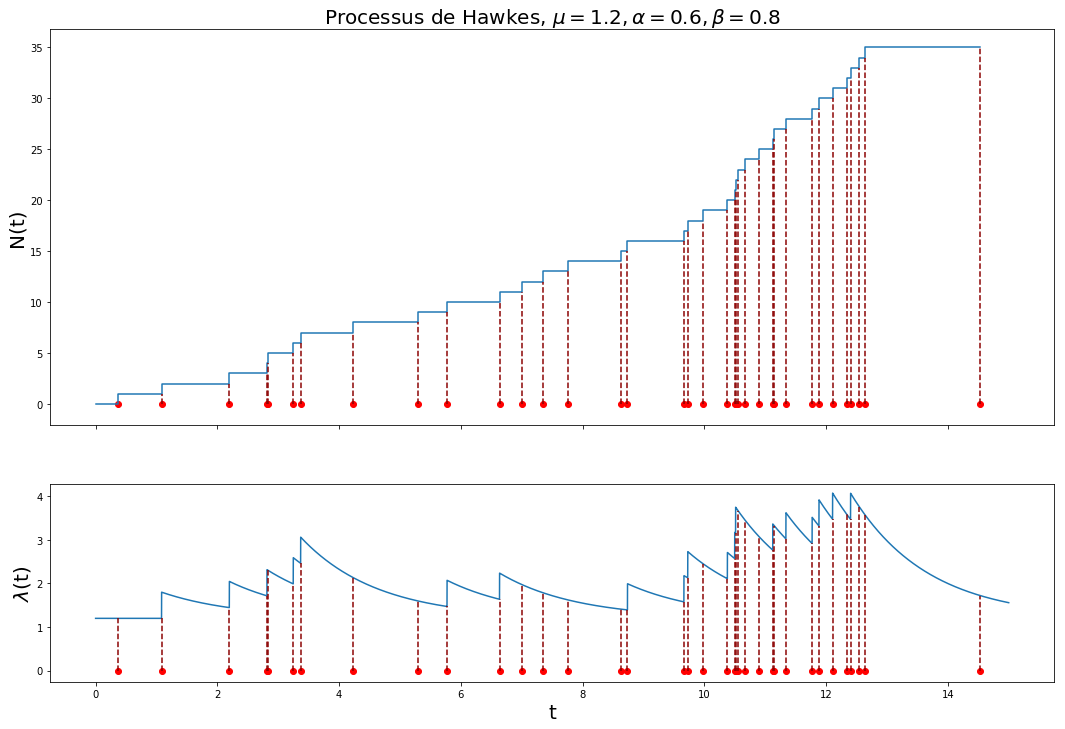

In [50]:
mu = 1.2
sigma = 1
alpha = 0.6
beta = 0.8
S = 3
plot_Hawkes_Seuil(mu, alpha, beta, T, S)